In [60]:
# Import Libraries
import gc
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
random.seed(3) # setting random state
import lightgbm as lgb  # import LightGBM
from sklearn.metrics import f1_score  # import F1_score
from sklearn.model_selection import train_test_split

In [61]:
# Load in the dataset
dataset = pd.read_csv("C:\Akeed Restauant Recommendation Challenge\Dataset\cleaned_dataset_real.csv")

In [62]:
# function to reduce memory usage
## Reduce memory usage
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

dataset['vendor_tag_name'] = dataset['vendor_tag_name'].str.replace(' ', '_')

# Vectorize the vendor_tag_names
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer()
X = vec.fit_transform(dataset['vendor_tag_name'])
tags_name = pd.DataFrame(X.toarray(), columns=vec.get_feature_names()) # create the tag_names dataframe
tags_name = reduce_mem_usage(tags_name) # reduce memory usage 

# concat dataset and tags_name
dataset = pd.concat([dataset, tags_name], axis=1)

Mem. usage decreased to 763.56 Mb (75.0% reduction)


In [63]:
# calculate seconds from preparation time 
dataset['preptime_seconds'] = dataset['prepration_time']*60

columns = dataset.columns.tolist() # add columns to a list

# remove target variables
target_column = ['CID X LOC_NUM X VENDOR', 'target'] #
for col in target_column:
    columns.remove(col)
    
# # removing the following columns from 
feature_importance = ['verified', 'status']

for col in feature_importance:
    columns.remove(col)    
    

In [78]:
# define categoriccal columns
cat_cols =['vendor_category_en', 'customer_id', 
            'location_type', 'id', 'OpeningTime',
            'delivery_charge', 'vendor_tag_name',
           'vendor_category_id', 'language_x']

# converting categorical features to category
for c in cat_cols:
    dataset[c] = dataset[c].astype('category')

In [66]:
# calculate mean latitude and longitude from latitude and longitude column
location= dataset.groupby('customer_id').mean()[['longitude_x','latitude_x']]
dataset = pd.merge(dataset, location, left_on='customer_id', right_on='customer_id')

# determine variables and target columns
# columns.remove('OpeningTime')# remove openingtimes column but add it back latter

dataset['OpeningTime'] = dataset['OpeningTime'].str.replace('Other', '00000000') #10591059
    
# convert the values in the Openingtimes column to integers
dataset['OpeningTime'] = pd.to_numeric(dataset['OpeningTime'])

In [67]:
# remove location
remove_loc = ['latitude_x', 'longitude_x']
for col in remove_loc:
    columns.remove(col)
    
# add latitude_x_x and longitude_x_x to the columns
columns.append("latitude_x_x")
columns.append("longitude_x_x")
columns.append('longitude_x_y')
columns.append('latitude_x_y')

In [68]:
# # split into test and train dataset
# train, test, train_label, test_label = train_test_split(dataset[columns], dataset['target'], random_state=1)
# print(train.shape) 
# print(test.shape)
gc.collect()
columns
dataset = reduce_mem_usage(dataset)

Mem. usage decreased to 1168.99 Mb (31.7% reduction)


### Model

In [69]:
#intialize the dataset and search parameters
gc.collect()
train_data = lgb.Dataset(dataset[columns], dataset['target'],     
                     feature_name = columns, categorical_feature=cat_cols)

# defining parameters
SEARCH_PARAMS = {'learning_rate': [0.05],
                'max_depth': [16],
                 'boosting_type': 'gbdt',
                'num_leaves': [600],
                'feature_fraction': 0.8,
                'subsample': 0.3}

In [70]:
# train the model
gc.collect()
import time
start = time.time()
model = lgb.train(SEARCH_PARAMS, train_data,             
                     num_boost_round=300)
gc.collect()
end = time.time()
print(end - start)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


340.310533285141


In [ ]:
# import logloss metric
from sklearn.metrics import log_loss

# Make predictions on the train dataset and view it log loss 
log_loss(train_label, model.predict(train))

In [19]:
# Make predictions on the test dataset and view it log loss
log_loss(test_label, model.predict(test))

0.00016213285499306137

In [20]:
# Since this is a binary prediction, we would predict 1 if the probability is just > 0.005
test['pred']= model.predict(test)
test['gt005'] = (test['pred']>0.005).astype(int)

In [21]:
# import f1_score
from sklearn.metrics import f1_score

# view the f1_score of the model's prediction on the test dataset
f1_score(test_label, test['gt005'])

0.8625415834996674

In [22]:
# giving a threshold 
values = [0.06, 0.061, 0.062, 0.063, 0.064, 0.065, 0.066, 0.067, 0.068, 0.069]
for value in values:
    test['gt05'] = (test['pred']>value).astype(int)
    print(value, f1_score(test_label, test['gt05']))

0.06 1.0
0.061 1.0
0.062 1.0
0.063 1.0
0.064 1.0
0.065 1.0
0.066 1.0
0.067 1.0
0.068 1.0
0.069 1.0


In [23]:
values = [0.09, 0.091, 0.092, 0.094, 0.095, 0.097, 0.98, 0.99]
for value in values:
    test['gt05'] = (test['pred']>value).astype(int)
    print(value, f1_score(test_label, test['gt05']))

0.09 1.0
0.091 1.0
0.092 1.0
0.094 1.0
0.095 1.0
0.097 1.0
0.98 0.9977321925574683
0.99 0.9785423506237689


In [24]:
# Defining a list for possible thresholds for a better f1_score
values = [0.08, 0.81, 0.082, 0.084, 0.085, 0.087, 0.88, 0.89] 

# pass the list into a for loop and predict
for value in values:
    test['gt05'] = (test['pred']>value).astype(int)
    print('Threshold', value, f1_score(test_label, test['gt05']))

Threshold 0.08 1.0
Threshold 0.81 1.0
Threshold 0.082 1.0
Threshold 0.084 1.0
Threshold 0.085 1.0
Threshold 0.087 1.0
Threshold 0.88 1.0
Threshold 0.89 1.0


In [379]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def plotImp(model, X , num = 20):
    feature_imp = pd.DataFrame({'Value':model.feature_importance(),'Feature':X.columns})
    plt.figure(figsize=(80, 40))
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')   
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()


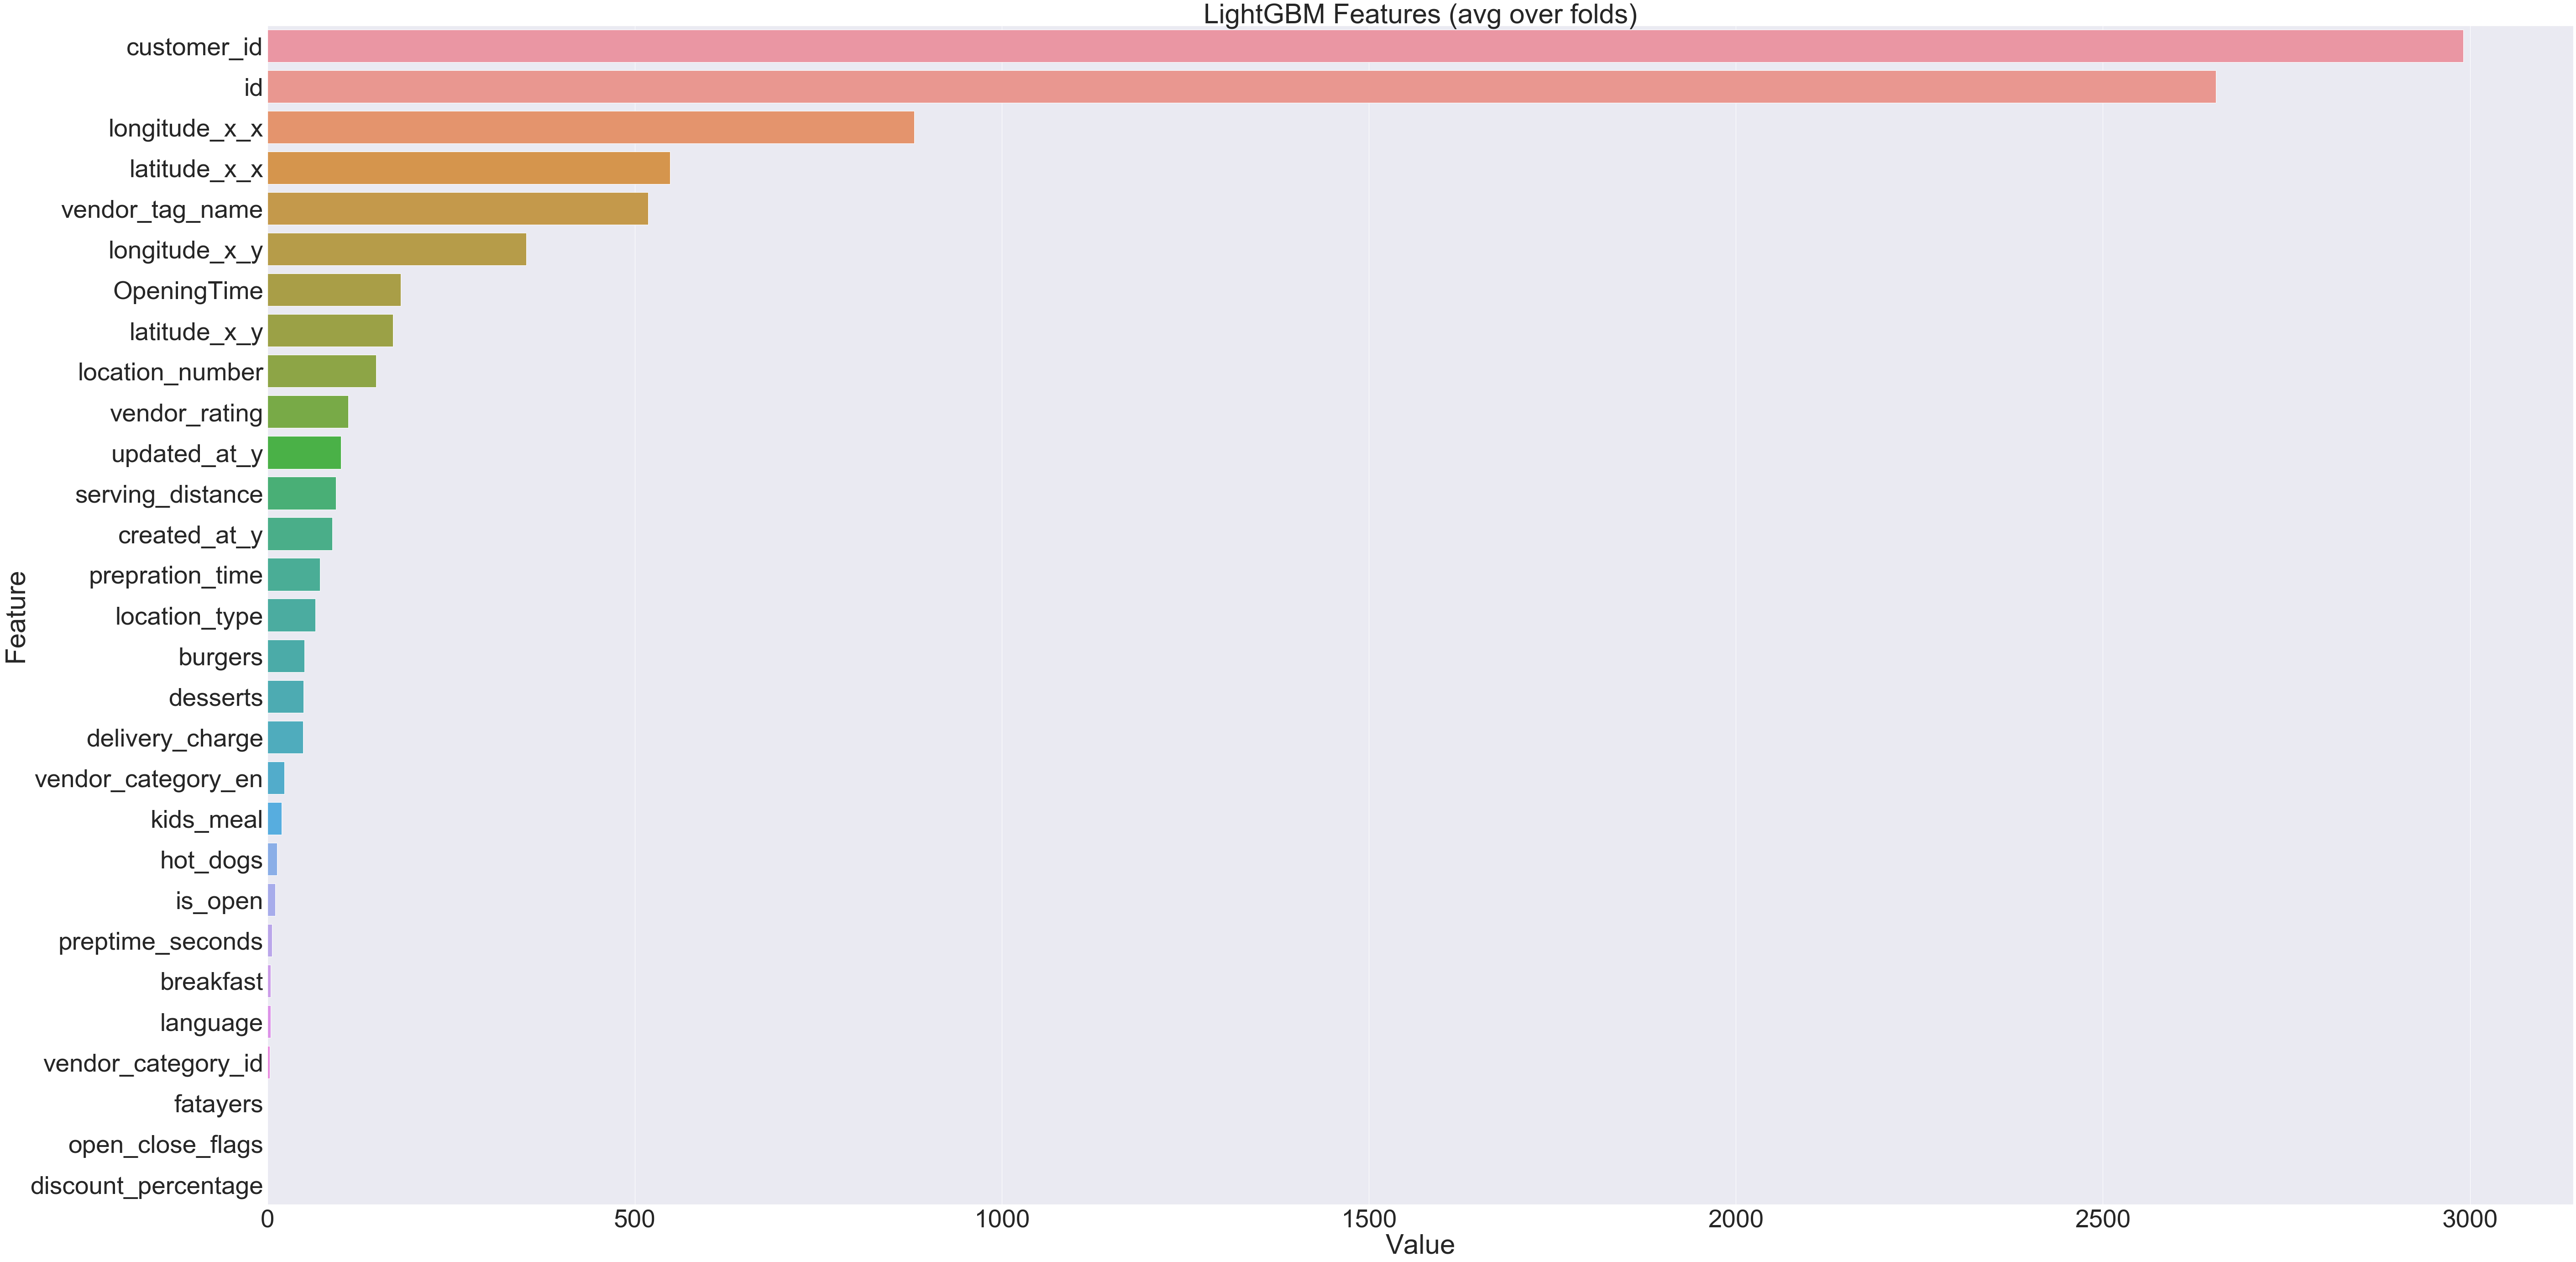

In [368]:
plotImp(model, train, num=35)

In [71]:
# import submission file
sub_file = pd.read_csv('C:/Akeed Restauant Recommendation Challenge/akeed_sun.csv')

In [30]:
dataset

,CID X LOC_NUM X VENDOR,target
0,Z59FTQD X 0 X 4,0
1,Z59FTQD X 0 X 13,0
2,Z59FTQD X 0 X 20,0
3,Z59FTQD X 0 X 23,0
4,Z59FTQD X 0 X 28,0
...,...,...
1671995,3O8LSR3 X 0 X 849,0
1671996,3O8LSR3 X 0 X 855,0
1671997,3O8LSR3 X 0 X 856,0
1671998,3O8LSR3 X 0 X 858,0


In [31]:
dataset.to_csv('C:\Akeed Restauant Recommendation Challenge\sun_file2.csv', index = False)